In [ ]:
import numpy as np
from matplotlib import pyplot as plt
import math
import scipy.io
import nibabel as nib
from skimage.transform import rescale
import time
from scipy.signal import medfilt
import multiprocessing
from torch.multiprocessing import Pool, Process, set_start_method
import pywt
from google.colab import files
import torch

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
uploaded = files.upload()

Saving utils.py to utils.py


In [ ]:
from utils import *

In [ ]:
#Upload image for testing
uploaded = files.upload()

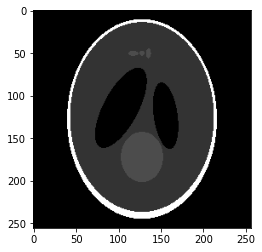

In [ ]:
# mat = scipy.io.loadmat('./shepp_logan.mat')
# x = mat['x']
# mat = scipy.io.loadmat('./drive/MyDrive/Colab Notebooks/14am_T1P1_CBCT_MDL_vert5x5_norm.mat')
# x = mat['CBCTMDLvert5x5_14am_norm']
#x.shape
mat = scipy.io.loadmat('./drive/MyDrive/Colab Notebooks/shepp_logan_256.mat')
x = mat['x']
x.shape
plt.imshow(x[:,:,128], cmap='gray')
plt.show()

In [ ]:
# plt.imshow(x[:,:,32], cmap='gray')
# plt.show()

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

mh,nh,th = x.shape

scale = 2
dr = scale; dc = scale; ds = scale
d = dr*dc*ds

ml = int(mh/dr)
nl = int(nh/dc)
tl = int(th/ds)
m = ml*nl*tl

blksz = [ml, nl, tl] # size of the LR image

# filter size and std of the Gaussian filter
psf_sz = 9
gaussian_std = 3
# create gaussian filter 
H = fspecial3('gaussian', psf_sz, gaussian_std)

# we pad the blurring kernel and blur the image in the Fourier domain
# we pad the blurring kernel

m0, n0, t0 = H.shape
#pads1, pads2 = torch.floor([(mh-m0+1)/2,(nh-n0+1)/2,(th-t0+1)/2]).astype(int), np.around([(mh-m0-1)/2,(nh-n0-1)/2,(th-t0-1)/2]).astype(int)
pads1, pads2 = np.floor([(mh-m0+1)/2,(nh-n0+1)/2,(th-t0+1)/2]).astype(int), np.around([(mh-m0-1)/2,(nh-n0-1)/2,(th-t0-1)/2]).astype(int)
hpad = np.pad(H , ((pads1[0],pads2[0]),(pads1[1],pads2[1]),(pads1[2],pads2[2])) )
#hpad = np.asarray(hpad)
#hp_c = np.fft.fftshift(hpad)
#hp_c = np.asarray(hp_c)
#hp_c = np.asarray(hp_c)
#FB = np.fft.fftn(hp_c)
## print("fftn")
#FBC = np.conjugate(FB)
## Crash in here
#F2B = np.absolute(FB)**2
## print("END1")

hpad = torch.tensor(hpad).to(device)
hp_c = torch.fft.fftshift(hpad).to(device)
FB = torch.fft.fftn(hp_c).to(device)
FBC = torch.conj(FB).to(device)
F2B = torch.square(torch.abs(FB)).to(device)

# we blur the image in in the fourier domain.
# Hx = np.real(np.fft.ifftn(np.matmul(np.asarray(FB), x)))
# Hx = np.real(np.fft.ifftn(np.multiply(FB,np.fft.fftn(x))))
# Hx = np.real(np.fft.ifftn(FB*np.fft.fftn(x)))
x_pytorch = torch.tensor(x).to(device)
Hx = torch.real(torch.fft.ifftn(FB*torch.fft.fftn(x_pytorch))).to(device)
print(Hx.shape)

torch.Size([256, 256, 256])


In [ ]:
def fro(aa):
    """
    This function gives the Frobenius norm of a 3D volume
    """
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    result = torch.square(aa)
    return torch.sqrt(torch.sum(result))

#we decimate the blurred image
SHx = Hx[0:Hx.shape[0]:dr,0:Hx.shape[1]:dc,0:Hx.shape[2]:ds]

#we add noise
N = SHx.shape[0]*SHx.shape[1]*SHx.shape[2]
BSNRdb = 10

noise_sigma = fro(SHx-torch.mean(SHx))/torch.sqrt(torch.tensor(N*10**(BSNRdb/10)).to(device))
noise = noise_sigma.cpu()*torch.randn(SHx.shape[0],SHx.shape[1],SHx.shape[2])

noise_var = noise_sigma**2

SHx_n = SHx + noise.to(device)
# plt.imshow(np.uint8(SHx_n.cpu()*255)[:,:,16], cmap='gray')
# plt.show()

In [ ]:
def PSNR(orig_im, est_im):
    d1 = torch.max(orig_im)
    d2 = torch.max(est_im)
    d = d1 if d1 > d2 else d2
    mse = torch.sum((orig_im-est_im)**2)/(torch.tensor(orig_im.shape[0]*orig_im.shape[1]*orig_im.shape[2]))
#     print(d,mse)
    PSNR = 10 * torch.log10(d**2/mse)
    return PSNR

x = torch.tensor(x).to(device)
## Restoring the image by interpolation method
SHx_n_cpu = SHx_n.cpu()
x_est = rescale(SHx_n_cpu, scale, preserve_range=True, anti_aliasing=True)
x_est = torch.tensor(x_est).to(device)
psnr_in = PSNR(x, x_est)
print('interpolation PSNR = ', psnr_in)

f_x_est = medfilt(x_est.cpu())
f_x_est = torch.tensor(f_x_est).to(device)
# lmax = 3
# basis = 'haar'
# mu = thrextr_3d(x_est,basis)
# f_x_est = ST3Dwt(x_est, basis, lmax, mu)
# f_x_est1 = bm4d(x_est, noise_var)

psnr_den = PSNR(x,f_x_est)
print('deniosed_psnr: PSNR = ',psnr_den)

## we upsample using the idea of conjugate transpose 
# DTy = np.zeros((mh,nh,th))
# DTy[0:mh:dr,0:nh:dc,0:th:ds] = SHx_n
DTy = torch.zeros((mh,nh,th))
DTy[0:mh:dr,0:nh:dc,0:th:ds] = SHx_n

interpolation PSNR =  tensor(20.2226, device='cuda:0', dtype=torch.float64)
deniosed_psnr: PSNR =  tensor(20.3006, device='cuda:0', dtype=torch.float64)


In [ ]:
def fd(mat, nR, nC, nS):
    return ipermute(np.reshape(mat, [nR, nC, nS], order='F'), [0, 1, 2])

def ipermute(mat, order):
    inverseorder = np.zeros(len(order), dtype='int')
    inverseorder[order] = [i for i in range(len(order))]
    return permute(mat, inverseorder)

def permute(mat, order):
    return np.transpose(mat, order)

def ufd_1(A, R, C): 
    """
    les dimensions (R et C) commencent à 0 en python et non à 1 comme dans Matlab !
    """
    I = A.shape
    J = np.prod([I[r] for r in R])
    K = np.prod([I[c] for c in C])
    L = np.transpose(A, np.append(R, C))
    return L.reshape([J, K], order='F') 

def blcthre3d(im, blksz):
    """
    Divide the image into small blocks by blksz
    Sum of blocks as vector by row
    The result returned is the same size with blksz

    For exemple : 
    im (64,64,64) blksz (32,32,32)
    We sum block by block : 
        block 1 : im[0:32,0:32,0:32]
        block 2 : im[0:32,0:32,32:64]
        ...
        block 8 : im[32:64,32:64,32:64]
    blocvec : (32768,8) // 32*32*32 = 32768
    Sum of blocks as vector by row => (32768,1) => reshape with size blksz
    """
    if len(blksz) == 0:
        blksz = im.shape

    #image size
    imsz = im.shape

    #starting points
    sr = np.array([x for x in range(0, imsz[0], blksz[0])])
    sc = np.array([x for x in range(0, imsz[1], blksz[1])])
    ss = np.array([x for x in range(0, imsz[2], blksz[2])])

    # end points
    er = sr + blksz[0] - 1
    ec = sc + blksz[1] - 1
    es = ss + blksz[2] - 1
    
#     print(sr,er)
#     print(sc,ec)
#     print(ss,es)

    # number of blocks in each dimension
    nbr = len(sr)
    nbc = len(sc)
    nbs = len(ss)

    # compute size of vectorized block
    szbl = blksz[0] * blksz[1] * blksz[2]

    # vector matrix
#     print(szbl,(imsz[0]/blksz[1])*(imsz[1]/blksz[1])*(imsz[2]/blksz[2]))
    blocvec = np.zeros((szbl, int((imsz[0]/blksz[0])*(imsz[1]/blksz[1])*(imsz[2]/blksz[2]))),dtype=np.complex128)
    
#     print(blocvec.shape)
    #fun = lambda ufd_1, x, m : ufd_1(x, [1], [2, 3]).reshape(m, 1)
    index = 0
    # iterate all image blocks
    for i in range(nbr):
        for j in range(nbc):
            for k in range(nbs):
#                 print(i,j,k)
                # process current image block
#                 ufd_1(A=im[sr[i]:er[i]+1, sc[j]:ec[j]+1, ss[k]:es[k]+1],R = [0],C=[1,2])
                prblk = ufd_1(A=im[sr[i]:er[i]+1, sc[j]:ec[j]+1, ss[k]:es[k]+1],R = [0],C=[1,2]).reshape([szbl,1],order='F')
#                 prblk = fun(im[sr[i]:er[i]+1, sc[j]:ec[j]+1, ss[k]:es[k]+1])
#                 np.squeeze(prblk)
#                 print(type(prblk[0,0]))
                blocvec[:, index] = np.squeeze(prblk)
                index = index + 1
    blocvec = torch.tensor(blocvec).to(device)
    blocsin = torch.sum(blocvec, axis=1)
#     print(blocsin)
    blocresult = fd(blocsin.cpu().numpy(), blksz[0], blksz[1], blksz[2])
    
    return blocresult


In [ ]:
def multiply(x,invWBR1):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    return (torch.tensor(x).to(device)*invWBR1).cpu().numpy()

def blockproc3(im, blksz, invWBR1, border=[0,0,0], useparallel=False):
    """
    """
    if len(blksz) == 0:
        blksz = im.shape
    
    # for convenience, we need the size vector to have 3 components, even for a 2D image
    if len(blksz) < 3:
        blksz[2] = 1
    
    imsz = im.shape

    # starting points
    r0 = np.array([x for x in range(0, imsz[0], blksz[0])])
    c0 = np.array([x for x in range(0, imsz[1], blksz[1])])
    s0 = np.array([x for x in range(0, imsz[2], blksz[2])])

    # end points
    rx = r0 + blksz[0] - 1
    cx = c0 + blksz[1] - 1
    sx = s0 + blksz[2] - 1
    rx = np.array([min(x, imsz[0]) for x in rx])
    cx = np.array([min(x, imsz[1]) for x in cx])
    sx = np.array([min(x, imsz[2]) for x in sx])

    # block limits with the extra borders
    # starting points
    br0 = np.array([max(x - border[0], 0) for x in r0])
    bc0 = np.array([max(x - border[1], 0) for x in c0])
    bs0 = np.array([max(x - border[2], 0) for x in s0])

    # end points
    brx = np.array([min(x + border[0], imsz[0]) for x in rx])
    bcx = np.array([min(x + border[1], imsz[1]) for x in cx])
    bsx = np.array([min(x + border[2], imsz[2]) for x in sx])

    # number of blocks in each dimension
    NR = len(r0)
    NC = len(c0)
    NS = len(s0)
    
#     print(r0,rx,br0,brx)

    # init output
    im2 = np.zeros_like(im)
#     im2=im

    # parallel procesing
    if useparallel:
        #torch.multiprocessing.set_start_method('spawn', force=True)
        # number of blocks
        numblocks = NR * NC * NS
        
        # generate all input blocks (loops are in inverted order, so that linear indices follow 1, 2, 3, 4...)
        list_params = []
        blocks = []
        for i in range(NR):
            for j in range(NC):
                for k in range(NS):
#                     idx = sub2ind([NR, NC, NS], i, j, k)
#                     blocks[idx] = im[br0[i]:brx[i]+1, bc0[j]:bcx[j]+1, bs0[k]:bsx[k]+1]
                    list_params.append([im[br0[i]:brx[i]+1, bc0[j]:bcx[j]+1, bs0[k]:bsx[k]+1],invWBR1])
        pool = Pool(processes=multiprocessing.cpu_count())
        blocks = pool.starmap(multiply,list_params)
#         im2 = pool.starmap(multiply, range(numblocks))
        pool.close()
        pool.join()
        

        for b in range(numblocks):
            # block's array indices from linear indices
#           [i, j, k] = ind2sub([len(br0), len(bc0), len(bs0)], b)
            [i, j, k] = np.unravel_index(b, (len(br0), len(bc0), len(bs0)))
#             print(i, j, k)
            # assign result to output removing the borders
            im2[r0[i]:rx[i]+1, c0[j]:cx[j]+1, s0[k]:sx[k]+1] = blocks[b][r0[i]-br0[i]:(rx[i]-br0[i]+1),
                                                                        c0[j]-bc0[j]:(cx[j]-bc0[j]+1),
                                                                        s0[k]-bs0[k]:(sx[k]-bs0[k]+1)]
    # single processor (we save memory by not creating a cell vector with all the blocks)                                                               s0[k]-bs0[k]+1:sx[k]-bs0[k]+1]
    else:
        for i in range(NR):
            for j in range(NC):
                for k in range(NS):
                    aux = multiply(im[br0[i]:brx[i]+1, bc0[j]:bcx[j]+1, bs0[k]:bsx[k]+1],invWBR1)
#                     print(i,j,k)
                    # assign result to output removing the borders
#                     print(im2[r0[i]:rx[i]+1, c0[j]:cx[j]+1, s0[k]:sx[k]+1].shape)
#                     print(aux[r0[i]-br0[i]+1:(brx[i]-rx[i])+1,c0[j]-bc0[j]+1:(bcx[j]-cx[j])+1,s0[k]-bs0[k]+1:(bsx[k]-sx[k])+1].shape)
                    im2[r0[i]:rx[i]+1, c0[j]:cx[j]+1, s0[k]:sx[k]+1] = aux[r0[i]-br0[i]:(aux.shape[0]-(brx[i]-rx[i])),
                                                                     c0[j]-bc0[j]:(aux.shape[1]-(bcx[j]-cx[j])),
                                                                     s0[k]-bs0[k]:(aux.shape[2]-(bsx[k]-sx[k]))]

    return im2

In [ ]:
def runfp(x_est):
    max_iter = 101
    sumLoop = 0
    sumLoop_part1 = 0 
    sumLoop_part2 = 0
    sumLoop_part3 = 0 
    lam = 1e1*noise_var
    print('iter \tPSNR \tTotal_time  \tTime_Denoiser \tTime_FFT \tTime_InverseFFT\n')
    for i in range(max_iter):
        timeLoop = time.time()
        # Apply the denoiser
        timeLoop_part1 = time.time()
        f_x_est = medfilt(x_est.cpu().numpy())
        f_x_est = torch.tensor(f_x_est).to(device)
        sumLoop_part1 += time.time() - timeLoop_part1
#         lmax = 3
#         basis = 'haar'
#         mu = thrextr_3d(x_est,basis)
#         f_x_est = ST3Dwt(x_est, basis, lmax, mu)

        # Determine FFT of k
        timeLoop_part2 = time.time()
        FR1 = FBC * torch.fft.fftn(DTy).to(device) + torch.fft.fftn(lam * f_x_est)
        F2D = 1

        # Entrywise product
        x11 = FB * FR1/F2D
        FBR1 = torch.tensor(blcthre3d(x11.clone().cpu().numpy(), blksz)).to(device)
        invW1 = torch.tensor(blcthre3d((F2B / F2D).clone().cpu().numpy(), blksz)).to(device)
        invWBR1 = FBR1 / (invW1 + lam * d)
        sumLoop_part2 += time.time() - timeLoop_part2

        # Inverse FFT and subtract from k
        timeLoop_part3 = time.time()
        FCBinvWBR1 = blockproc3(FBC.clone().cpu().numpy(), blksz, invWBR1, useparallel=False)
        FX1 = (FR1-torch.tensor(FCBinvWBR1).to(device))/F2D/lam
        x_est = torch.real(torch.fft.ifftn(FX1))
        sumLoop_part3 += time.time() - timeLoop_part3
        # esp = torch.norm((x_est_new-x_est))
        # if (esp < 1e-3): 
        #   print(esp)
        #   break
        # x_est = x_est_new

        TL = time.time() - timeLoop
        sumLoop = sumLoop + TL
        if i%10 == 0:          
            im_out = x_est
            psnr_out = PSNR(x, im_out)
            print('{} {:.3f} {:.3f}\t {:.3f}\t {:.3f}\t {:.3f}'.format(i, psnr_out, sumLoop, sumLoop_part1 ,sumLoop_part2, sumLoop_part3))

    im_out = x_est
    psnr_out = PSNR(x, im_out)
    return im_out,psnr_out

In [ ]:
im_out,psnr_out = runfp(x_est)

iter 	PSNR 	Total_time  	Time_Denoiser 	Time_FFT 	Time_InverseFFT

0 22.615 29.590	 27.461	 1.664	 0.466
10 23.756 322.124	 296.829	 19.819	 5.476
20 23.802 615.353	 567.017	 37.841	 10.495
30 23.813 906.136	 835.361	 55.468	 15.308
40 23.882 1196.927	 1103.704	 73.097	 20.126
50 23.938 1488.503	 1372.966	 90.573	 24.964
60 23.972 1780.608	 1642.848	 107.987	 29.772
70 23.968 2073.107	 1913.279	 125.271	 34.557
80 23.995 2366.295	 2184.349	 142.602	 39.344
90 24.001 2658.433	 2454.485	 159.810	 44.138
100 24.005 2950.410	 2724.696	 176.818	 48.895


In [ ]:
0 22.615    29.590	     27.461	 1.664	    0.466
10 23.756   322.124	    296.829	 19.819	    5.476
20 23.802   615.353	    567.017	 37.841	    10.495
30 23.813   906.136	    835.361	 55.468	    15.308
40 23.882   1196.927	 1103.704	 73.097	    20.126
50 23.938   1488.503	 1372.966	 90.573	    24.964
60 23.972   1780.608	 1642.848	 107.987	 29.772
70 23.968   2073.107	 1913.279	 125.271	 34.557
80 23.995   2366.295	 2184.349	 142.602	 39.344
90 24.001   2658.433	 2454.485	 159.810	 44.138
100 24.005  2950.410	 2724.696	 176.818	 48.895

Text(0.5, 1.0, 'RED: FP 24.01dB')

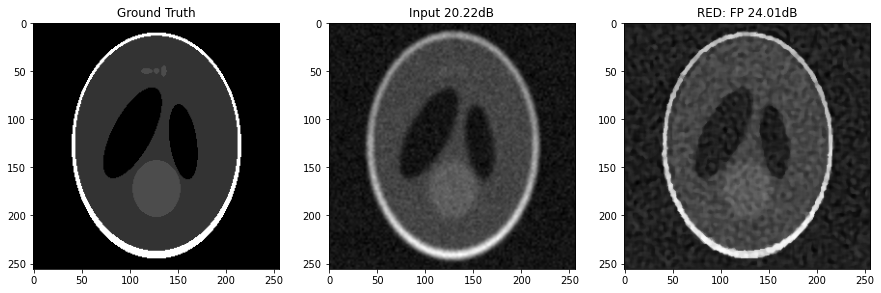

In [ ]:
# create figure
fig = plt.figure(figsize=(15, 7))
rows = 1
columns = 3

# Adds a subplot at the 1st position
fig.add_subplot(rows, columns, 1) 
# showing image
plt.imshow(x.cpu()[:,:,128], cmap='gray')
# plt.axis('off')
plt.title("Ground Truth")

# Adds a subplot at the 2nd position
fig.add_subplot(rows, columns, 2) 
# showing image
plt.imshow(x_est.cpu()[:,:,128],cmap='gray')
# plt.axis('off')
plt.title("Input {:.2f}dB".format(psnr_in))

# Adds a subplot at the 3rd position
fig.add_subplot(rows, columns, 3) 
# showing image
plt.imshow(im_out.cpu()[:,:,128],cmap='gray')
# plt.axis('off')
plt.title("RED: FP {:.2f}dB".format(psnr_out))

In [ ]:
with open('./drive/MyDrive/Colab Notebooks/im_out_256.npy', 'wb') as f:
    np.save(f, im_out.cpu().numpy())
f.close()

Text(0.5, 1.0, 'RED: FP 24.03dB')

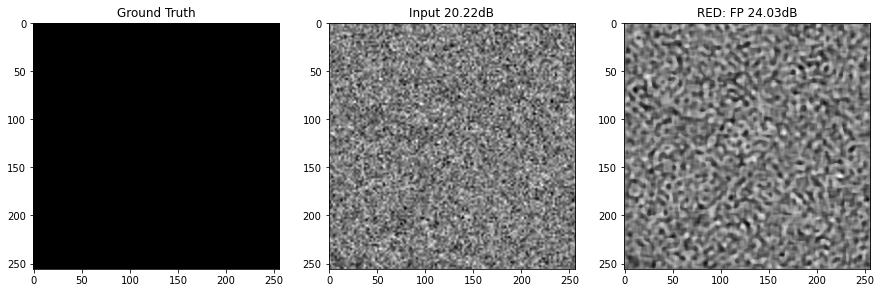

In [ ]:
# create figure
fig = plt.figure(figsize=(15, 7))
rows = 1
columns = 3

# Adds a subplot at the 1st position
fig.add_subplot(rows, columns, 1) 
# showing image
plt.imshow(x[:,:,16], cmap='gray')
# plt.axis('off')
plt.title("Ground Truth")

# Adds a subplot at the 2nd position
fig.add_subplot(rows, columns, 2) 
# showing image
plt.imshow(x_est[:,:,16],cmap='gray')
# plt.axis('off')
plt.title("Input {:.2f}dB".format(psnr_in))

# Adds a subplot at the 3rd position
fig.add_subplot(rows, columns, 3) 
# showing image
plt.imshow(im_out[:,:,16],cmap='gray')
# plt.axis('off')
plt.title("RED: FP {:.2f}dB".format(psnr_out))